# Телеком отток

**Заказчик**: Оператор мобильный связи  
**Задача**: модель предсказания оттока клиентов  
**Данные**: персональные данные абонентов, информацию об их тарифах и договорах. 7000+ строк  
**Актуальность**: 2013-2020  
**Описание**: Оператор предоставляет два основных типа услуг:  
1. Телефонная связь с возможностью подключение нескольких линий.
2. Интернет. Два типа: DSL или Fiber optic
Помимо этого доступен выбор доп.опций:
- антивирус  
- стриминговое ТВ
- онлайн-кинотеатр  
и т.п.  

За услуги клиенты могут платить каждый месяц или заключить договор на 1-2 года. Доступны различные способы расчёта и возможность получения электронного чека.  

**Цель работы:** На основе анализа клиентского портфеля выявить потнциальных отписчиков, настроить модель предсказания оттока клиентов. По результатам прогноза предлагать промокоды тем, кто склонен к оттоку.  

**Метрика**: Метрика ROC-AUC не ниже 0.85

# План проекта
1. **Знакомство с данными**
- изучение датасета
- объединение датасета
- визуализация датасета
2. **Предобработка**
- работа с пропусками
- работа с некорректными значениями
- фильтрация 
- выделение таргета
- выделение доп.признаков
- унификация бинарных признаков
3. **EDA**
- исследовательский анализ предобработанного датасета
- мультиколлинеарность
- выводы
4. **Выбор модели**
- анализ  моделей машинного обучения: случайный лес, градиентный бустинг
- подготовка выводов
5. **Тест модели**
- запуск модели на тестовой выборке
- оценка результатов и подготовка выводов
6. **Общий вывод по проекту** 

### Знакомство с данными

**Необходимые импорты**

In [1]:
!pip install phik

**Знакомство с датасетами**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import phik
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.metrics import precision_recall_curve, accuracy_score
from catboost import Pool
from catboost import cv
warnings.filterwarnings("ignore")
np.random.seed(220523)

In [3]:
contract = pd.read_csv('/datasets/contract_new.csv')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
contract.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [5]:
contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
personal = pd.read_csv('/datasets/personal_new.csv')
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
personal.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


In [8]:
personal.sample(4)

,customerID,gender,SeniorCitizen,Partner,Dependents
6551,6728-VOIFY,Female,0,Yes,No
5645,4942-VZZOM,Male,0,Yes,No
2783,4760-THGOT,Female,0,Yes,No
4792,7067-KSAZT,Female,1,Yes,No


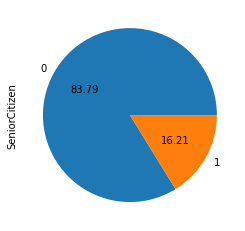

In [9]:
personal['SeniorCitizen'].value_counts().plot.pie(autopct='%.2f')
plt.show()

In [10]:
internet = pd.read_csv('/datasets/internet_new.csv')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
internet.describe().T

,count,unique,top,freq
customerID,5517,5517,6778-YSNIH,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


In [12]:
internet.sample(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
527,3509-GWQGF,Fiber optic,No,No,No,No,No,No
3843,7839-NUIAA,DSL,Yes,Yes,No,No,No,No
5289,3855-ONCAR,Fiber optic,No,No,No,No,Yes,No


In [13]:
phone = pd.read_csv('/datasets/phone_new.csv')
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
phone.describe().T

,count,unique,top,freq
customerID,6361,6361,7841-TZDMQ,1
MultipleLines,6361,2,No,3390


In [15]:
phone.sample(3)

,customerID,MultipleLines
6142,3541-ZNUHK,Yes
429,0486-LGCCH,No
2416,3550-SAHFP,Yes


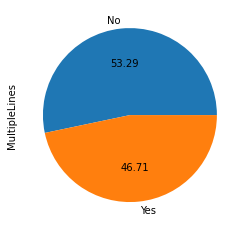

In [16]:
phone['MultipleLines'].value_counts().plot.pie(autopct='%.2f')
plt.show()

**Объединение датасетов в один**

In [17]:
df = pd.merge(personal, contract, on='customerID', how='left')
df = pd.merge(df, internet, on='customerID', how='left')
df = pd.merge(df, phone, on='customerID', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


**Описание столбцов**

**customerID** - id клиента  
**gender** - пол  
**SeniorCitizen** - признак пожилого  
**Partner** - признак супруга  
**Dependents** - иждевенцы  
**BeginDate** - дата начала  
**EndDate** - дата оттока  
**Type** - тип оплаты(ежемесячный или годовой)  
**PaperlessBilling** - признак безналичного расчёта  
**PaymentMethod** - способ оплаты  
**MontlyCharges** - ежемесячный траты  
**TotalCharges** - всего потрачено денег на услуги  
**MultipleLines** - признак многоканального телефона  
**StreamingMovies** - признак стримингого сервиса  
**StreamingTV** - признак ТВ  
**TechSupport** - техподдержка  
**PaperlessBilling** - требует ли чек  


In [18]:
df.sample(7)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
4465,3606-SBKRY,Male,0,No,No,2017-07-01,No,One year,Yes,Electronic check,50.05,1551.55,DSL,No,No,Yes,No,Yes,Yes,NaN
1427,6896-SRVYQ,Male,1,No,No,2016-06-01,No,Month-to-month,No,Electronic check,73.85,3249.4,Fiber optic,No,No,Yes,No,No,No,No
4081,7665-TOALD,Female,0,No,No,2019-12-01,No,Month-to-month,Yes,Electronic check,69.60,139.2,Fiber optic,No,No,No,No,No,No,No
5025,7326-RIGQZ,Male,0,Yes,Yes,2019-08-01,No,Month-to-month,Yes,Electronic check,69.80,418.8,Fiber optic,No,No,No,No,No,No,No
2685,5781-BKHOP,Female,0,Yes,No,2014-02-01,No,Two year,No,Bank transfer (automatic),100.65,7246.8,Fiber optic,Yes,Yes,Yes,No,Yes,No,Yes
1838,8058-DMYRU,Male,1,No,No,2015-08-01,No,Month-to-month,Yes,Electronic check,90.05,4862.7,Fiber optic,No,Yes,No,No,No,Yes,Yes
4863,8727-JQFHV,Male,0,Yes,Yes,2015-05-01,2018-03-01,Two year,No,Mailed check,20.75,705.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [19]:
selected_cols = ['SeniorCitizen', 'MonthlyCharges']
corr_matrix = df[selected_cols].corr()
corr_matrix 

,SeniorCitizen,MonthlyCharges
SeniorCitizen,1.000000,0.220173
MonthlyCharges,0.220173,1.000000


**Вывод**: В рамках задачи было предоставлено 4 датасета разного объема. Все датасеты имеют общий уникальный столбец - customerID. В датасетах отсутствует выделенный таргет, его нужно выделить самостоятельно на основании столбца с датой ухода клиента. Также необходимо:  
- очистить столбец с общей суммой за услуги
- преобразовать столбцы с датами
- дропнуть столбец с датой окончания во избежании утечки
- заполнить пропуски, которые появились при объединении

### Предобработка

**Дубликаты**

In [20]:
mydups = df.duplicated().sum()
print('Количество полных дубликтов в датасете', mydups)

Количество полных дубликтов в датасете 0


**Оптимизация 1 и 0**

In [21]:
def true_false(x):
    if x ==  "Yes":
        return 1
    elif x == 'No':
        return 0

In [22]:
oe_encode = ['Partner','Dependents','PaperlessBilling', 
             'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
             'TechSupport','StreamingTV', 'StreamingMovies', 'MultipleLines' ]
for i in oe_encode:
    df[i] = df[i].apply(true_false)

df.sample(7)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
1039,9948-YPTDG,Male,0,1,0,2016-10-01,2019-03-01,Month-to-month,1,Electronic check,79.45,2419.25,Fiber optic,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6450,4609-KNNWG,Female,0,1,1,2017-11-01,No,Two year,0,Mailed check,19.90,585.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6523,2834-JKOOW,Female,0,0,0,2018-11-01,No,One year,0,Mailed check,45.90,688.5,DSL,1.0,1.0,1.0,1.0,0.0,0.0,NaN
3411,7056-IMHCC,Male,1,1,0,2015-05-01,2017-08-01,Month-to-month,1,Electronic check,101.90,3026.43,Fiber optic,0.0,1.0,0.0,0.0,1.0,1.0,1.0
716,0114-IGABW,Female,0,1,0,2014-03-01,2016-11-01,Two year,0,Bank transfer (automatic),58.25,1975.84,DSL,0.0,1.0,1.0,1.0,1.0,1.0,NaN
1932,3247-MHJKM,Male,0,0,0,2020-01-01,No,Month-to-month,0,Mailed check,20.20,20.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4071,6537-QLGEX,Female,0,0,0,2018-10-01,No,Month-to-month,1,Electronic check,38.90,622.4,DSL,1.0,0.0,0.0,0.0,1.0,0.0,NaN


**Выделение таргета**

In [23]:
def target(x):
    if x == 'No':
        return 0
    else:
        return 1

In [24]:
df['Target'] = df['EndDate'].apply(target)
df.sample(7)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target
3741,2984-TBYKU,Male,0,1,1,2014-02-01,2017-09-01,Two year,1,Credit card (automatic),...,4781.34,Fiber optic,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1
993,9108-EQPNQ,Female,0,1,1,2019-04-01,No,Two year,0,Credit card (automatic),...,281.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
5216,3034-ZBEQN,Female,0,1,0,2016-01-01,2018-09-01,One year,0,Mailed check,...,1177.02,DSL,0.0,1.0,1.0,0.0,0.0,0.0,NaN,1
3337,0840-DFEZH,Female,0,0,0,2019-07-01,No,Month-to-month,1,Electronic check,...,527.45,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
6056,8331-ZXFOE,Female,0,0,0,2015-04-01,No,One year,1,Credit card (automatic),...,4165.04,DSL,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0
3751,2522-AHJXR,Male,0,1,0,2015-02-01,2016-11-01,Month-to-month,1,Bank transfer (automatic),...,2436.36,Fiber optic,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1
3621,2933-FILNV,Female,0,1,1,2019-11-01,No,Month-to-month,1,Mailed check,...,73.2,DSL,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0


In [25]:
selected_cols = ['TotalCharges', 'MonthlyCharges','Target' ]
corr_matrix = df[selected_cols].corr()
corr_matrix 

,MonthlyCharges,Target
MonthlyCharges,1.000000,0.154286
Target,0.154286,1.000000


**Котрольная доля отточников**

In [26]:
print(f'Доля отточников в датафрейме {round(df["Target"].mean() *100, 2)}%')

Доля отточников в датафрейме 15.63%


**Пропуски**

In [27]:
pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('gnuplot')

,0
customerID,0.000000
gender,0.000000
SeniorCitizen,0.000000
Partner,0.000000
Dependents,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000


**Общие сборы по клиенту**  

Так как в поле с цифрами присутствуют строки их необходимо отфильтрова для дальнейшей работы.

In [28]:
non_numeric_values = df[~pd.to_numeric(df['TotalCharges'], errors='coerce').notnull()]
len(non_numeric_values)

11

In [29]:
non_numeric_values

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target
488,4472-LVYGI,Female,0,1,1,2020-02-01,No,Two year,1,Bank transfer (automatic),...,,DSL,1.0,0.0,1.0,1.0,1.0,0.0,NaN,0
753,3115-CZMZD,Male,0,0,1,2020-02-01,No,Two year,0,Mailed check,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
936,5709-LVOEQ,Female,0,1,1,2020-02-01,No,Two year,0,Mailed check,...,,DSL,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0
1082,4367-NUYAO,Male,0,1,1,2020-02-01,No,Two year,0,Mailed check,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
1340,1371-DWPAZ,Female,0,1,1,2020-02-01,No,Two year,0,Credit card (automatic),...,,DSL,1.0,1.0,1.0,1.0,1.0,0.0,NaN,0
3331,7644-OMVMY,Male,0,1,1,2020-02-01,No,Two year,0,Mailed check,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
3826,3213-VVOLG,Male,0,1,1,2020-02-01,No,Two year,0,Mailed check,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
4380,2520-SGTTA,Female,0,1,1,2020-02-01,No,Two year,0,Mailed check,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
5218,2923-ARZLG,Male,0,1,1,2020-02-01,No,One year,1,Mailed check,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
6670,4075-WKNIU,Female,0,1,1,2020-02-01,No,Two year,0,Mailed check,...,,DSL,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0


В срез попали все клиенты, которые пришли в компанию в день выгрузки. Очистим датасет от этих клиентов, так как эти данные малоинформативны в контексте задачи.

In [30]:
index_to_drop = non_numeric_values.index.tolist()
df.drop(index_to_drop, inplace=True)
len(df)

7032

In [31]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [32]:
selected_cols = ['MonthlyCharges', 'TotalCharges', 'Target']
corr_matrix = df[selected_cols].corr()
corr_matrix 

,MonthlyCharges,TotalCharges,Target
MonthlyCharges,1.000000,0.630297,0.153927
TotalCharges,0.630297,1.000000,0.051548
Target,0.153927,0.051548,1.000000


**Работа с датами**

In [33]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   int64         
 4   Dependents        7032 non-null   int64         
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           7032 non-null   object        
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   int64         
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  InternetService   5512 non-null   object        
 13  OnlineSecurity    5512 non-null   float64       
 14  OnlineBackup      5512 n

In [34]:
def end_date(x):
    if x == "No":
        return ''
    else:
        x = pd.to_datetime(x)
        return x

In [35]:
df['EndDate'] = df['EndDate'].apply(end_date)

In [36]:
df['EndDate'] = pd.to_datetime(df['EndDate'])

In [37]:
max_date = df['BeginDate'].max()
min_date = df['BeginDate'].min()
print(f'Данные представлены за период c {min_date} по {max_date}')

Данные представлены за период c 2013-10-01 00:00:00 по 2020-01-01 00:00:00


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   int64         
 4   Dependents        7032 non-null   int64         
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           1101 non-null   datetime64[ns]
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   int64         
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  InternetService   5512 non-null   object        
 13  OnlineSecurity    5512 non-null   float64       
 14  OnlineBackup      5512 n

**Добавим доп.признак - кол-во дней сотрудничества для всех клиентов**

In [39]:
def happy_days(row):
    if pd.isna(row['EndDate']):
        const_date = datetime.datetime(2020, 2, 1, 0, 0)
        y = (const_date - row['BeginDate']).days
        return y
    else:
        x = (row['EndDate'] - row['BeginDate']).days
        return x

In [40]:
df['happy_days'] = df.apply(happy_days, axis=1) 

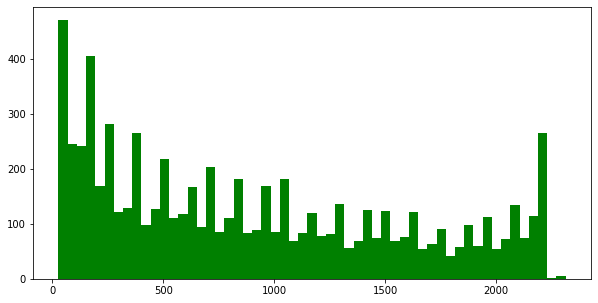

In [41]:
df['happy_days'].hist(grid=False, figsize = (10,5), color='green', bins=55)
plt.show()

In [42]:
df_BeginDate_all = df['BeginDate']

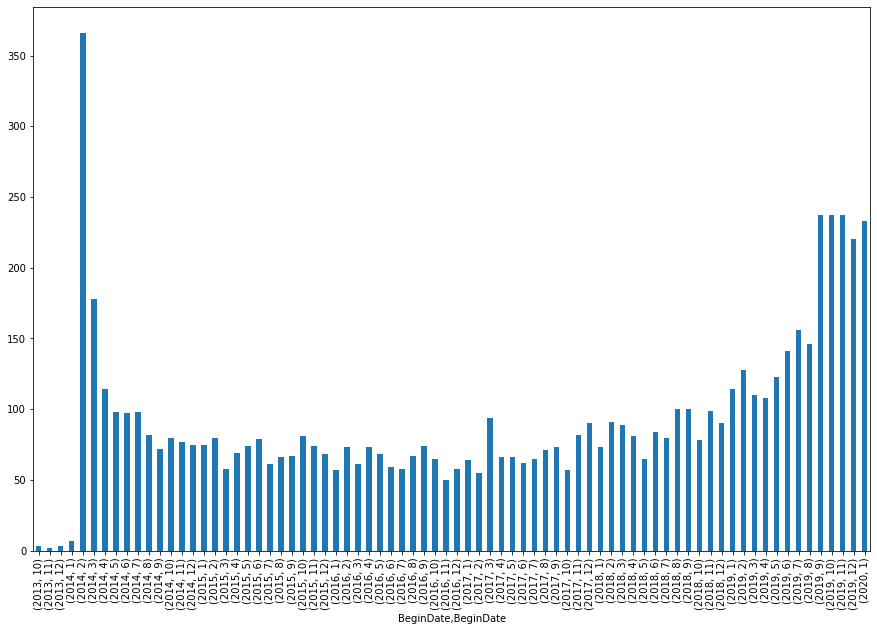

In [43]:
df_BeginDate_all.groupby([df_BeginDate_all.dt.year, df_BeginDate_all.dt.month]).count().plot(kind="bar", figsize = (15,10))
plt.show()

Добавим доп.признак - кол-во дней сотрудничества для всех тех кто отписался от сервиса. Изучим его, но в модели использовать не будем.

In [44]:
df_signout = df.query("Target == 1")
df_BeginDate_signout = df_signout['BeginDate']
df_EndDate_signout = df_signout['EndDate']

df_BeginDate_signin_count  = df_BeginDate_signout.groupby([df_BeginDate_signout.dt.year, df_BeginDate_signout.dt.month]).count()
df_BeginDate_signin_cumsum = df_BeginDate_signin_count.cumsum()

df_EndDate_signout_count = df_EndDate_signout.groupby([df_EndDate_signout.dt.year, df_EndDate_signout.dt.month]).count()
df_EndDate_signout_cumsum = df_EndDate_signout_count.cumsum()

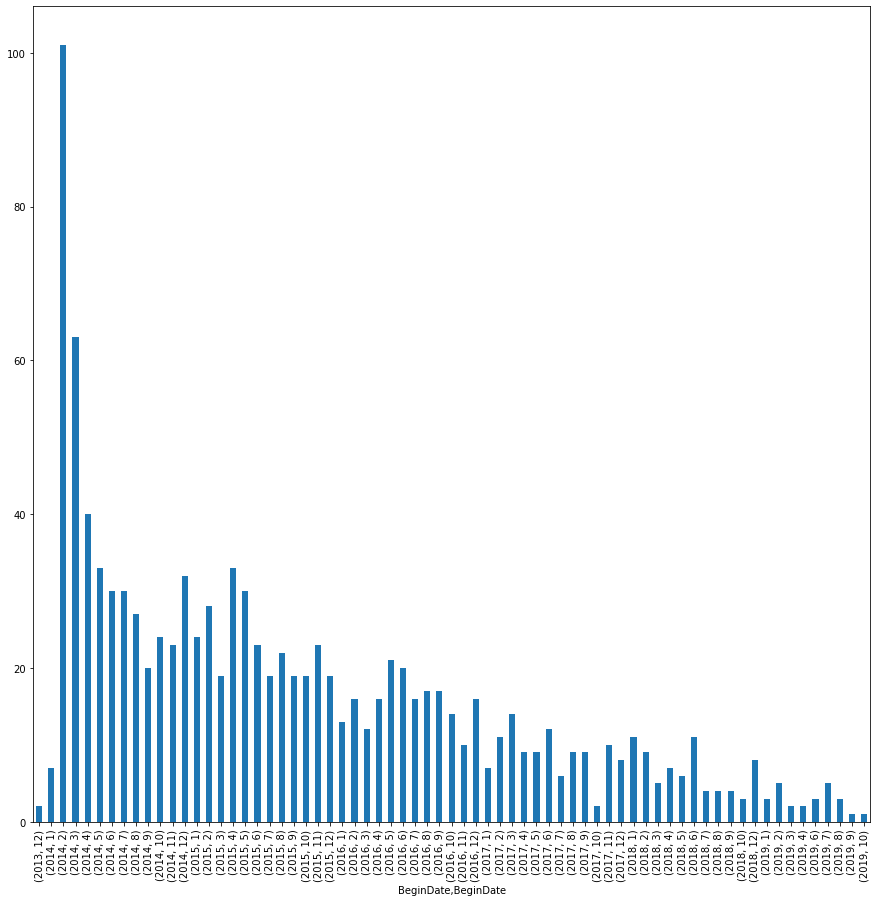

In [45]:
df_BeginDate_signin_count.plot(kind="bar", figsize = (15,15))
plt.show()

**Добавим доп.признак - средняя стоимость одного для обслуживания для каждого клиента**

In [46]:
df['day_price'] = df['TotalCharges'] / df['happy_days']

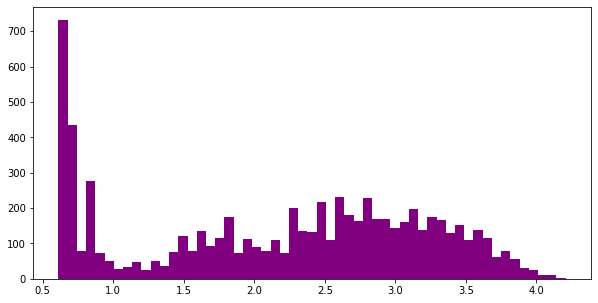

In [47]:
df['day_price'].hist(grid=False, figsize = (10,5), color='purple', bins=55)
plt.show()

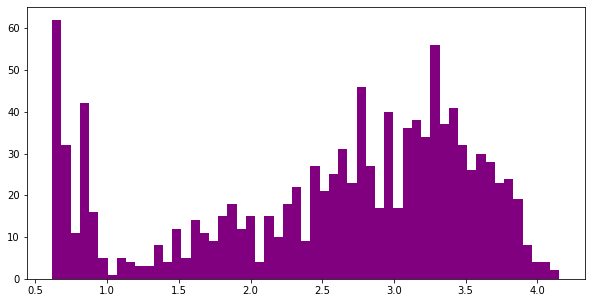

In [48]:
clients_away = df.query('Target == 1')
clients_away['day_price'].hist(grid=False, figsize = (10,5), color='purple', bins=55)
plt.show()

**Заполнение пропусков**

In [49]:
df.fillna(0, inplace=True)

In [50]:
pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('gnuplot')

,0
customerID,0.000000
gender,0.000000
SeniorCitizen,0.000000
Partner,0.000000
Dependents,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000


**Дроп столбцов**

In [51]:
df = df.drop(columns=['EndDate', 'customerID', 'BeginDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   int64  
 3   Dependents        7032 non-null   int64  
 4   Type              7032 non-null   object 
 5   PaperlessBilling  7032 non-null   int64  
 6   PaymentMethod     7032 non-null   object 
 7   MonthlyCharges    7032 non-null   float64
 8   TotalCharges      7032 non-null   float64
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   float64
 11  OnlineBackup      7032 non-null   float64
 12  DeviceProtection  7032 non-null   float64
 13  TechSupport       7032 non-null   float64
 14  StreamingTV       7032 non-null   float64
 15  StreamingMovies   7032 non-null   float64
 16  MultipleLines     7032 non-null   float64


In [52]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Target', 'happy_days', 'day_price']


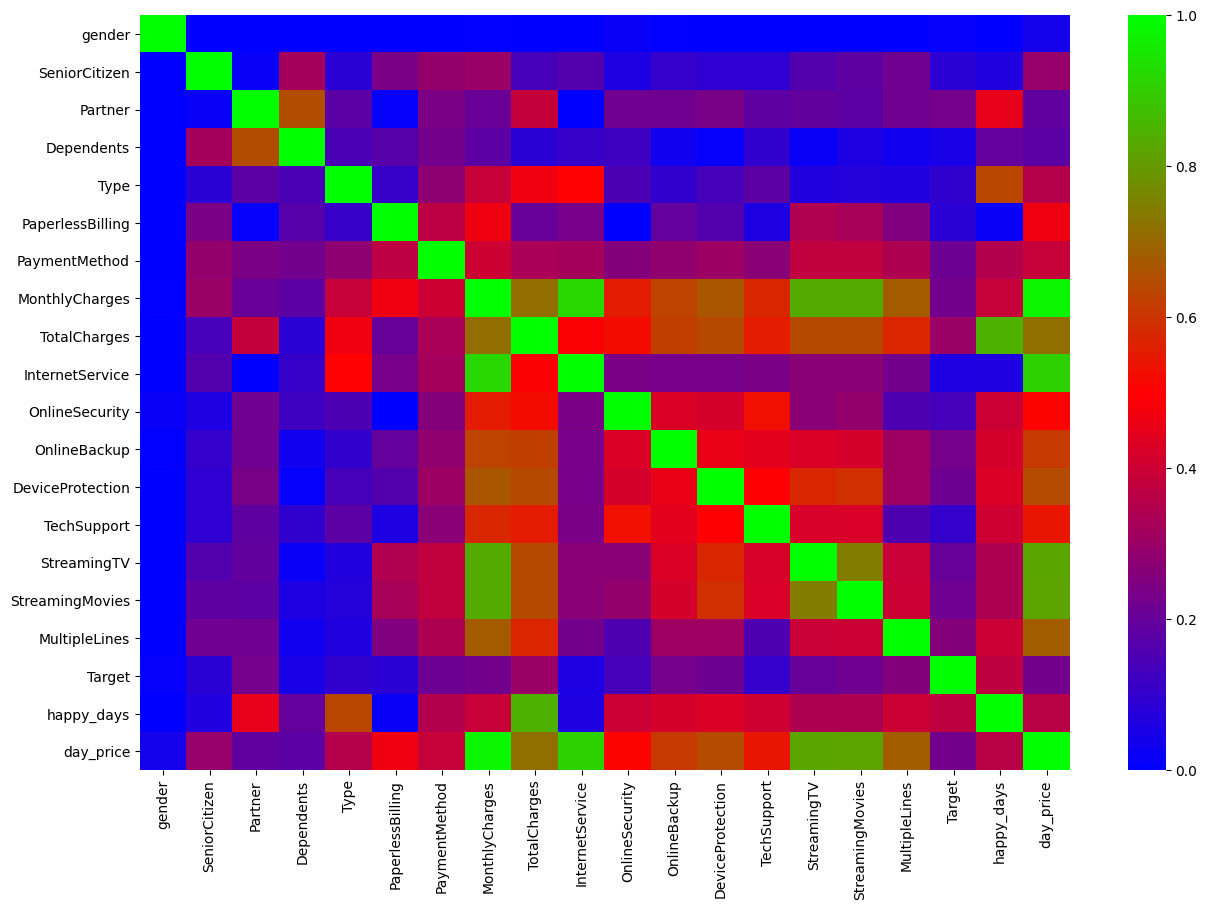

In [53]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=100)
sns.heatmap(data = phik_overview, cmap='brg')
plt.show()

In [54]:
phik_overview['Target'].sort_values(ascending=False).reset_index().style.background_gradient('gist_ncar')

,index,Target
0,Target,1.000000
1,happy_days,0.374101
2,TotalCharges,0.303758
3,MultipleLines,0.261345
4,OnlineBackup,0.229736
5,Partner,0.227597
6,day_price,0.226463
7,MonthlyCharges,0.225823
8,StreamingMovies,0.221756
9,DeviceProtection,0.218622


**Вывод**: наиболее важными признаками можно назвать количество дней в компании, общую сумму оплаты за весь период, использование многоканальной линии. А вот пол настолько не важен, что его можно смело удалить из датасета, как бесполезный.

### EDA

**Пол клиента**

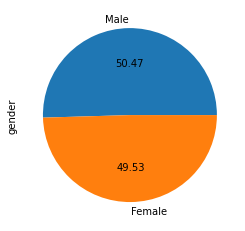

In [55]:
df['gender'].value_counts().plot.pie(autopct='%.2f')
plt.show()

In [56]:
df.groupby('gender')['Target'].agg(['count', 'mean'])

,count,mean
gender,,
Female,3483,0.151593
Male,3549,0.161454


**Вывод**: количество мужчин и женщин в датасете практически идентично. Их показатели отточности практически не отличаются.

**Клиент-пенсионер**

In [57]:
df.groupby('SeniorCitizen')['Target'].agg(['count', 'mean'])

,count,mean
SeniorCitizen,,
0,5890,0.147538
1,1142,0.203152


**Вывод**: Около 15% клиентов - пенсионеры. При этом среди них показатель отточности значительно выше среднего показателя. 
Вероятно пенсионеры - группа риска по оттоку.

**Наличие супруга/супруги**

In [58]:
df.groupby('Partner')['Target'].agg(['count', 'mean'])

,count,mean
Partner,,
0,3639,0.104974
1,3393,0.211907


**Вывод**: Количество людей в браке и вне его в датасете примерно одинаково.  
Однако, показатели отточности среди этих сегментов значительно различается.  
Люди вне брака - менее склонны к оттоку.
Люди в браке - более склонны к оттоку. **Это еще одна группа риска.**

**Наличие детей**

In [59]:
df.groupby('Dependents')['Target'].agg(['count', 'mean'])

,count,mean
Dependents,,
0,4933,0.148591
1,2099,0.175322


**Вывод**: В датасет попали преимущественно люди без детей. Таких около - 65%.  
Показатели отточности в них различаются, но не так критично, как в предыдущем сегменте.  
Люди с детьми более склонны к оттоку, чем без них. Возможно тут присутствует связь с людьми в браке.

In [60]:
df.groupby(['Dependents','Partner'])['Target'].agg(['count', 'mean'])

count      mean
Dependents Partner                 
0          0         3280  0.105488
           1         1653  0.234120
1          0          359  0.100279
           1         1740  0.190805

**Вывод 2**: Неожиданно: люди в браке и без детей наиболее склонны к отоку, доля 23%.  
Люди в браке тоже находятся в рисковой группе, доля 19%.  
А вот люди без детей и не в браке или с детьми, но не в браке имеют низкую долю оттока, всего 10%.

**Тип оплаты**

In [61]:
df.groupby('Type')['Target'].agg(['count', 'mean'])

,count,mean
Type,,
Month-to-month,3875,0.105032
One year,1472,0.212636
Two year,1685,0.226113


**Вывод**: сегментация по типу оплаты показывает большой разрыв в доле отточников.  
Люди, которые оплачивают связь сразу за год/несколько лет более склонны к оттоку, чем ежемесячные абоненты.

**Запрос чека**

In [62]:
df.groupby('PaperlessBilling')['Target'].agg(['count', 'mean'])

,count,mean
PaperlessBilling,,
0,2864,0.132682
1,4168,0.172985


**Вывод**: люди, которые запрашивают чек более склонны к оттоку, их доля 17%.

**Тип интернета**

In [63]:
df.groupby('InternetService')['Target'].agg(['count', 'mean'])

,count,mean
InternetService,,
0,1520,0.105263
DSL,2416,0.143212
Fiber optic,3096,0.192183


**Вывод**: высокая доля отточников среди клиентов оптоволоконного интернета - 19%.

**Общие сборы**

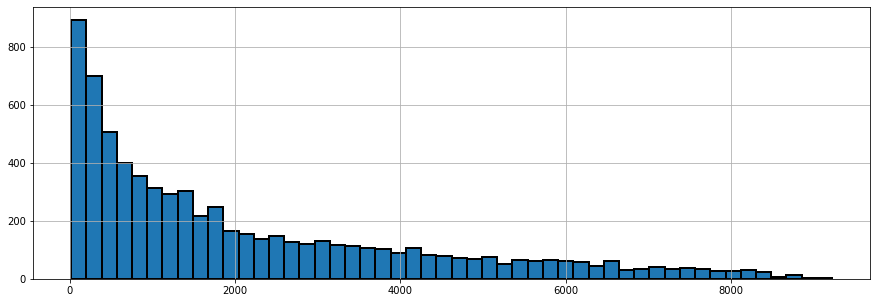

In [64]:
df['TotalCharges'].hist(bins=50, figsize=(15,5), ec='black', linewidth=2)
plt.show()

**Месячные сборы**

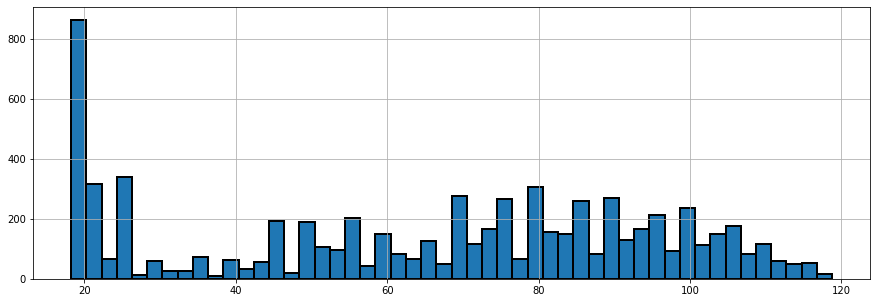

In [65]:
df['MonthlyCharges'].hist(bins=50, figsize=(15,5), ec='black', linewidth=2)
plt.show()

**Метод оплаты**

In [66]:
df.groupby('PaymentMethod')['Target'].agg(['count', 'mean'])

,count,mean
PaymentMethod,,
Bank transfer (automatic),1542,0.205577
Credit card (automatic),1521,0.208416
Electronic check,2365,0.147992
Mailed check,1604,0.072943


In [67]:
df.groupby(['PaymentMethod', 'PaperlessBilling'])['Target'].agg(['count', 'mean'])

count      mean
PaymentMethod             PaperlessBilling                 
Bank transfer (automatic) 0                   653  0.166922
                          1                   889  0.233971
Credit card (automatic)   0                   639  0.192488
                          1                   882  0.219955
Electronic check          0                   623  0.123596
                          1                  1742  0.156716
Mailed check              0                   949  0.074816
                          1                   655  0.070229

**Вывод**: Наибольшая доля отточников зафиксирована в сегментах с автоматическими платежами.

**Многоканальная линия**

In [68]:
df.groupby('MultipleLines')['Target'].agg(['count', 'mean'])

,count,mean
MultipleLines,,
0.0,4065,0.104059
1.0,2967,0.228514


**Вывод**: Самый существенный разрыв в отточниках по признаку многканальной связи.  
Почти 23% отточников среди клиентов, у которых подключена многоканальная связь.

**Вывод**  
**Пол**: значительных различий нет. Оба гендера склонны к оттоку примерно одинаково.  
**Статус пенсионера**: высокая доля отточников среди пенсионеров - группа риска.  
**Нахождение в браке**: люди с официально оформленными отношениями - группа риска. Разница с холостыми по оттоку более чем в два раза.
**Наличие детей**: люди с детьми более склонны к оттоку по сравнению с клиентами без детей.  
**Тип оплаты**: люди оплачивающие связь ежемесячно менее склонны к оттоку, чем люди с ежегодными(двухлетними) платежами. Разница более чем в 2 раза. Наиболее рисковая группа.  
**Тип оплаты**: клиенты с электронными чеками более склонны к оттоку.  
**Тип интернета**: по данному признаку наиболее рисковой группой являются пользователи проводного опто-волоконного интернета.  
**Метод оплаты**: выявлены рисковые группы связанны с рекурентными платежами(ежемесячные безакцептные списания). Стоит отметить, что эти сегмента коррелируют с типом оплаты и являются наиболее рисковыми.  
**Многоканальность**: одна из самых рисковых групп в контексте оттока это пользователя с многоканальной линией. В данным сегменте доля отточников наиболее трагичная


In [69]:
all_clients = df.query('Target == 0')
all_clients['day_price'].mean()

2.113380465435934

In [70]:
away_clients = df.query('Target == 1')
away_clients['day_price'].mean()

2.5515787653142814

**Вывод**
Отточные клиенты в среднем платят больше, чем те кто остался в компании.  
**2,55** против **2,12**

### Выбор модели

**Catboost**

In [71]:
train, test = train_test_split(df, train_size=0.75, random_state=220523, stratify=df['Target'])

In [72]:
print(train.shape)
print(test.shape)

(5274, 20)
(1758, 20)


In [73]:
print("Доля отточников в обучающей выборке", round(train['Target'].mean(),3))
print("Доля отточников в тестовой выборке:", round(test['Target'].mean(),3))

Доля отточников в обучающей выборке 0.157
Доля отточников в тестовой выборке: 0.156


In [74]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'Target', 'happy_days', 'day_price'],
      dtype='object')

In [75]:
df.sample(3)

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target,happy_days,day_price
1624,Female,0,1,0,One year,1,Electronic check,98.25,2554.50,Fiber optic,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1,792,3.225379
3157,Male,0,0,0,Month-to-month,0,Mailed check,44.95,509.28,DSL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,337,1.511217
5229,Female,1,1,0,One year,1,Electronic check,107.55,3161.97,Fiber optic,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1,852,3.711232


**Catboost**

In [76]:
X = ['SeniorCitizen', 'Partner', 'Dependents', 'Type',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
        'happy_days', 'day_price']

cat_features = ['Type', 'PaymentMethod', 'InternetService']
y = ['Target']

In [77]:
pool_train = Pool(data=train[X], label=train[y], cat_features = cat_features
                  )

pool_test =  Pool(data=test[X], label=test[y], cat_features = cat_features
                  )

In [78]:
params = {
          'random_seed':220523, 
          'learning_rate':0.015, 
          'eval_metric': 'AUC', 
        'auto_class_weights': 'Balanced',
         'loss_function': 'Logloss',
         }

In [79]:
cv_data = cv(params = params,
            pool = pool_train,
            fold_count = 5,
            partition_random_seed = 220523, 
            stratified=True,
            verbose=False)

Training on fold [0/5]

bestTest = 0.871666441
bestIteration = 997

Training on fold [1/5]

bestTest = 0.8426830099
bestIteration = 990

Training on fold [2/5]

bestTest = 0.8571467484
bestIteration = 984

Training on fold [3/5]

bestTest = 0.8504755087
bestIteration = 999

Training on fold [4/5]

bestTest = 0.8540409722
bestIteration = 999



In [80]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
999,999,0.85516,0.010687,0.475774,0.014428,0.333519,0.004055


In [81]:
params = {'verbose':100, 
          'random_seed':220523, 
          'learning_rate':0.015, 
          'eval_metric': 'AUC', 
         'auto_class_weights': 'Balanced',
         'loss_function': 'Logloss',
         'iterations': 990}
model = CatBoostClassifier(**params)
model.fit(pool_train)

0:	total: 10.4ms	remaining: 10.3s
100:	total: 822ms	remaining: 7.24s
200:	total: 1.57s	remaining: 6.16s
300:	total: 2.33s	remaining: 5.34s
400:	total: 3.06s	remaining: 4.49s
500:	total: 3.82s	remaining: 3.73s
600:	total: 4.59s	remaining: 2.97s
700:	total: 5.47s	remaining: 2.25s
800:	total: 6.37s	remaining: 1.5s
900:	total: 7.25s	remaining: 717ms
989:	total: 8.06s	remaining: 0us


In [82]:
print(classification_report(train[y],model.predict(pool_train)))

              precision    recall  f1-score   support

           0       0.98      0.81      0.88      4448
           1       0.46      0.89      0.61       826

    accuracy                           0.82      5274
   macro avg       0.72      0.85      0.75      5274
weighted avg       0.89      0.82      0.84      5274



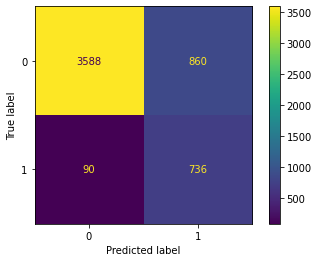

In [83]:
cm = confusion_matrix(train[y],model.predict(pool_train))
disp = ConfusionMatrixDisplay(cm)
disp.plot()

**Desicion Tree**

In [84]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [85]:
df_features, df_target = split_data(train, 'Target')

In [86]:
gender_ohe = pd.get_dummies(df_features["gender"], drop_first=True)
payment_ohe = pd.get_dummies(df_features["PaymentMethod"], drop_first=True)
type_ohe = pd.get_dummies(df_features["Type"], drop_first=True)
is_ohe = pd.get_dummies(df_features["InternetService"], drop_first=True)

df_features.drop(["gender", "PaymentMethod", "Type", "InternetService", 'MonthlyCharges'], axis=1, inplace=True)
df_ohe = pd.concat([df_features, gender_ohe, payment_ohe, type_ohe, is_ohe], axis=1)

In [87]:
df_features.head(5)

,SeniorCitizen,Partner,Dependents,PaperlessBilling,TotalCharges,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,happy_days,day_price
4096,0,0,0,1,1913.16,1.0,0.0,1.0,0.0,1.0,0.0,0.0,610,3.136328
5423,0,0,0,1,1212.75,0.0,0.0,0.0,0.0,0.0,1.0,0.0,457,2.653720
3628,0,0,0,1,625.50,1.0,0.0,1.0,1.0,1.0,0.0,0.0,276,2.266304
992,0,1,1,0,577.72,0.0,0.0,0.0,0.0,0.0,0.0,1.0,671,0.860984
2640,0,0,0,1,2088.90,0.0,1.0,1.0,1.0,0.0,1.0,0.0,671,3.113115


In [88]:
param_grid = {'min_samples_split': range(2, 15),
              'max_depth': [None, 6, 7, 8, 9, 10]
             }

model = DecisionTreeClassifier (random_state=220523)

grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='roc_auc'
                          )
grid_search.fit(df_features, df_target)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=220523),
             param_grid={'max_depth': [None, 6, 7, 8, 9, 10],
                         'min_samples_split': range(2, 15)},
             scoring='roc_auc')

In [89]:
grid_search.best_params_

{'max_depth': 6, 'min_samples_split': 14}

In [90]:
grid_search.best_score_

0.775827719684122

**Случайный лес**

In [91]:
par_grid_ensemble = {'n_estimators': [3, 10, 30],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 15)
                    }
model = RandomForestClassifier(random_state=220523)

grid_search = GridSearchCV(model, par_grid_ensemble, cv=5,
                           scoring='roc_auc'
                          )
grid_search.fit(df_features, df_target)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=220523),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': range(5, 15),
                         'n_estimators': [3, 10, 30]},
             scoring='roc_auc')

In [92]:
grid_search.best_params_

{'criterion': 'entropy', 'min_samples_split': 13, 'n_estimators': 30}

In [93]:
grid_search.best_score_

0.7959374091338993

**Логистическая регрессия**

In [94]:
par_grid_logist = {
                   'intercept_scaling': [0.5, 1.0, 1.5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.5, 1, 1.5]
                   }
model = LogisticRegression(solver='liblinear',random_state=220523)

grid_search = GridSearchCV(model, par_grid_logist, cv=5,
                           scoring='roc_auc')
grid_search.fit(df_features, df_target)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=220523,
                                          solver='liblinear'),
             param_grid={'C': [0.5, 1, 1.5], 'class_weight': [None, 'balanced'],
                         'intercept_scaling': [0.5, 1.0, 1.5]},
             scoring='roc_auc')

In [95]:
grid_search.best_params_

{'C': 1, 'class_weight': 'balanced', 'intercept_scaling': 0.5}

In [96]:
grid_search.best_score_

0.7206751909497167

**k ближайших соседей**

In [97]:
par_grid_kneigh = {
                   'n_neighbors': [5,10,15],
                   'leaf_size': [1,3,5],
                   'weights': ['uniform', 'distance'],
                   'algorithm': ['ball_tree', 'kd_tree']
                   }
model = KNeighborsClassifier()

grid_search = GridSearchCV(model, par_grid_kneigh, cv=5,
                           scoring='roc_auc')
grid_search.fit(df_features, df_target)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'leaf_size': [1, 3, 5], 'n_neighbors': [5, 10, 15],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [98]:
grid_search.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 1,
 'n_neighbors': 15,
 'weights': 'uniform'}

In [99]:
grid_search.best_score_

0.7271468589347434

### Тест модели

По результатам исследования лучшей моделью признан - Catboost. Проверим её на тестовой выборке.

In [100]:
params = {'verbose':100, 
          'random_seed':220523, 
          'learning_rate':0.015, 
          'eval_metric': 'AUC', 
         'auto_class_weights': 'Balanced',
         'loss_function': 'Logloss',
         'iterations': 990}
model = CatBoostClassifier(**params)
model.fit(pool_train)

0:	total: 8.8ms	remaining: 8.71s
100:	total: 754ms	remaining: 6.64s
200:	total: 1.47s	remaining: 5.78s
300:	total: 2.2s	remaining: 5.04s
400:	total: 2.87s	remaining: 4.21s
500:	total: 3.56s	remaining: 3.48s
600:	total: 4.29s	remaining: 2.78s
700:	total: 5.11s	remaining: 2.1s
800:	total: 5.99s	remaining: 1.41s
900:	total: 6.8s	remaining: 672ms
989:	total: 7.53s	remaining: 0us


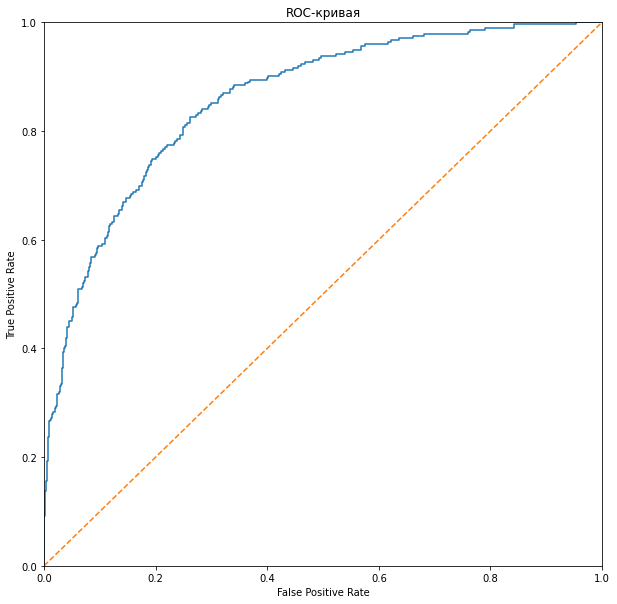

AUC: 0.8583877888800344


In [101]:
probabilities_test = model.predict_proba(test[X])
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(test[y], probabilities_one_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(test[y], probabilities_one_test)

print("AUC:", auc_roc)

In [102]:
print(classification_report(test[y],model.predict(pool_test)))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      1483
           1       0.40      0.77      0.52       275

    accuracy                           0.78      1758
   macro avg       0.67      0.78      0.69      1758
weighted avg       0.86      0.78      0.81      1758



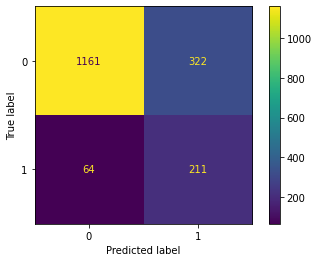

In [103]:
cm = confusion_matrix(test[y],model.predict(pool_test))
disp = ConfusionMatrixDisplay(cm)
disp.plot()

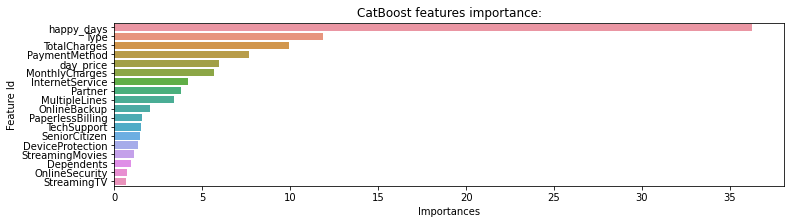

In [104]:
fi = model.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 3));
sns.barplot(x="Importances", y="Feature Id", data=fi);
plt.title('CatBoost features importance:');

**Вывод**: выбранная модель была протестирована на неизвестных ей данных, модели удалось пройти заданный порог в 0.85. При этом показатели precision и recall по положительному классу требуют дополнительных изучений, в контексте бизнеса. Если для бизнеса важно удержание максимального количества отточников, даже с учётом увеличения количества FP, то рекомендуется применение метода predict_proba и подбор оптимального порога учитвающего потребности и экономику бизнеса.

### Отчёт 


1. **Знакомство с данными**  
В рамках проекта была поставлена задача определить факторы влияющие на отказ клиента от обслуживания в телеком-компании и построить модель предсказывающую вероятность отказа клиента.  
На вход было получено 4 датасета, разной длины: от 5517 до 7043 строк. В рамках подготовки к предобработку данных, датасеты были объединены в 1 длинной 7043 строк.
2. **Предобработка**  
В ходе предобраотки была проведена проверка на наличие дубликатов, выделение таргета по дате ухода из компании, выявление аномалий в столбце по общим тратам за весь период обслуживания, изменение форматов дат, добавление нового признака количество дней в компании, изучение сезонности. После добавления признака по средней стоимости обслуживания в день на каждого клиента, выяснилось, что отточные клиенты платили больше.  
В заключительной части были дропнуты айди клиентов, как неинформативаные и даты, как источники утечки.
Далее c помощью phik_overview были визуализирована важность признаков.  
3. **EDA**  
В рамках EDA были изучены все важные признаки и выявлены следующие группы риска: пенсионеры, в браке, имеющие детей, оплачивающие телеком-услуги раз в 1-2 года, используюзие оптоволоконный интернет, использующие автоматическое списание через кредитку или банковский счёт, использующие многоканальную связь. 
4. **Выбор модели**  
Было рассмотрено 3 модели: CatBoostClassifier, Desicion Tree, RandomForestClassifier. По итогам исследования пороговое значение удалось пройти только модели CatBoostClassifier с результатом 0.85. Для деревянных моделей был применен ГридСерч для подбора гиперпараметров, а к категорилаьным переменным был применён One-Hot Encoding. Но это не дало ощутимых результатов и моделям не удалось пройти даже поро 0.80. 
5. **Тест модели**  
При тестировании CatBoostClassifie показал ROC-AUC - 0.859.
Отмечена возможность корректировки нужных метрик за счёт изменения порога.